# Spliting channels

In [4]:
from wfield import *
import tifffile
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import re
import shutil

In [2]:
data_folder = r'D:\data\aeltona\AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG'
# tif_file_path = pjoin(data_folder, 'scan9FN2ANVG_Oddball_AA_ROS-1706_2025_MMStack_Default.ome.tif')
tif_files = [f for f in os.listdir(data_folder) if f.endswith('.tif')]
localdisk = r'C:\datatemp'
dat_path = glob(pjoin(localdisk,'*.dat'))[0]



In [15]:
tif_data_list = []
for tif_file in sorted(tif_files):
    tif_file_path = os.path.join(data_folder, tif_file)
    tif_data = tifffile.imread(tif_file_path)
    tif_data_list.append(tif_data)

concatenated_data = np.concatenate(tif_data_list, axis=0)

<tifffile.TiffFile 'scan9FN2ANVG_Od…_Default.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'scan9FN2ANVG_Od…_Default.ome.tif'> MMStack series is missing files. Returning subset (5906, 1, 1, 1) of (18000, 1, 1, 1)
<tifffile.TiffFile 'scan9FN2ANVG_Od…efault_1.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'scan9FN2ANVG_Od…efault_1.ome.tif'> MMStack series is missing files. Returning subset (5906, 1, 1, 1) of (18000, 1, 1, 1)
<tifffile.TiffFile 'scan9FN2ANVG_Od…efault_2.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'scan9FN2ANVG_Od…efault_2.ome.tif'> MMStack series is missing files. Returning subset (5426, 1, 1, 1) of (18000, 1, 1, 1)


In [16]:
# Splitting into violet and green channels
violet_channel = concatenated_data[::2]  # Every second frame starting from the first
green_channel = concatenated_data[1::2]  # Every second frame starting from the second

# Ensure both channels have the same length (in case the number of frames is odd)
if violet_channel.shape[0] > green_channel.shape[0]:
    violet_channel = violet_channel[:-1]

In [25]:
merged_data.shape

(8619, 2, 600, 600)

In [21]:
h, w = green_channel.shape[1:]
# print(h,w)
merged_data = np.stack((violet_channel, green_channel), axis=1)



In [23]:
filename_parts = re.split(r'_|\.', tif_files[0])
# Extract relevant information from the filename parts
scan_info = '_'.join(filename_parts[0:4])  # Joining parts 1 to 4 with underscores
frame_shape = f"{h}_{w}"

# Define the filename
filename = f"{scan_info}_{frame_shape}_2_uint16.dat"
filename

'scan9FN2ANVG_Oddball_AA_ROS-1706_600_600_2_uint16.dat'

In [24]:
# Define the full path for saving the file
save_path = os.path.join(data_folder, filename)

# Save the merged data as a binary file
merged_data.astype(np.uint16).tofile(save_path)

# Motion Correction

In [28]:

temp_file_path = os.path.join(localdisk, filename)
shutil.copy(save_path, temp_file_path)


'C:\\datatemp\\scan9FN2ANVG_Oddball_AA_ROS-1706_600_600_2_uint16.dat'

In [29]:
# open file with read/write 
dat = mmap_dat(dat_path, mode='r+', nframes=8619, shape=(2, h, w))




In [31]:
dat.shape

(8619, 2, 600, 600)

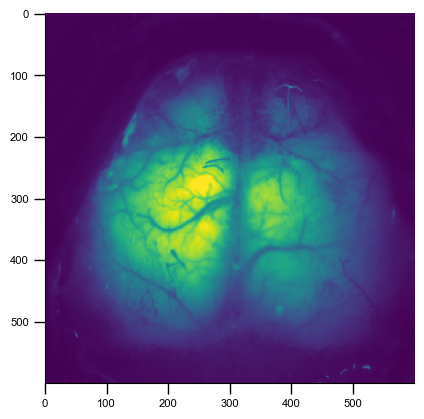

In [36]:
plt.imshow(dat[0,0,:,:])

In [37]:
(yshifts,xshifts),rot = motion_correct(dat,chunksize=512,
                                     apply_shifts=True)
del dat # close and finish writing


Motion correction: 100%|██████████| 17/17 [05:28<00:00, 19.32s/it]


In [38]:

# save the shifts
shifts = np.rec.array([yshifts,xshifts],dtype=[('y','float32'),('x','float32')])
np.save(pjoin(localdisk,'motion_correction_shifts.npy'),shifts)
np.save(pjoin(data_folder,'motion_correction_shifts.npy'),shifts)

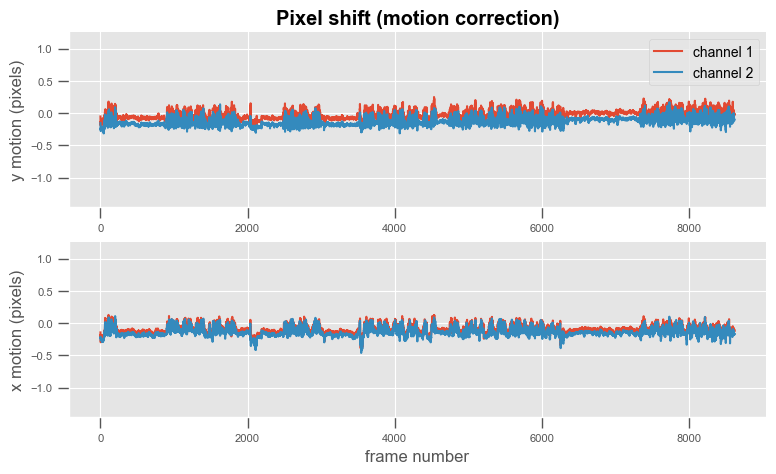

In [39]:
import pylab as plt
plt.matplotlib.style.use('ggplot')

%matplotlib inline

# localdisk = '/mnt/dual/temp_folder/CSP23_20200226' # this should be an SSD or a fast drive

shifts = np.load(pjoin(localdisk,'motion_correction_shifts.npy'))

plot_summary_motion_correction(shifts,localdisk);

In [3]:
# Look at the results
# %matplotlib qt5
dat = mmap_dat(dat_path, mode='r')
napari_show(dat)

: 

# Approximate single value decomposition

The aproximate implementation works by:
* binned the movie in 1 s bins (per channel)
* Estimating U from the binned movie.
* Iterating over the raw data to estimate S.VT 

Details in wfield-tools/decomposition.py 

The first example subtracts the average from each frame (i.e. the array in `frames_average` with 3 dimensions (ch,w,h)). The average can be the mean of all frames or only those in the baseline period of the experiment.


In [10]:
dat = mmap_dat(dat_path)
try:
    frames_average = np.load(pjoin(localdisk,'frames_average.npy')) # or see below (can also be computed using the baseline)
except Exception as e:
    print("Error:", e)
    print("Averaging frames...")
    chunkidx = chunk_indices(len(dat),chunksize=512)
    frame_averages = []
    for on,off in tqdm(chunkidx):
       frame_averages.append(dat[on:off].mean(axis=0))
    frames_average = np.stack(frame_averages).mean(axis = 0)
    np.save(pjoin(localdisk,'frames_average.npy'),frames_average)
    print(f"frames_average.npy saved in {localdisk}")


Error: [Errno 2] No such file or directory: 'C:\\datatemp\\frames_average.npy'
Averaging frames...


100%|██████████| 17/17 [00:09<00:00,  1.79it/s]

frames_average.npy saved in C:\datatemp


In [11]:
U,SVT = approximate_svd(dat, frames_average)
np.save(pjoin(localdisk,'U.npy'),U)
np.save(pjoin(localdisk,'SVT.npy'),SVT)

Binning raw data: 100%|██████████| 574/574 [01:11<00:00,  8.04it/s]


MemoryError: Unable to allocate 442. GiB for an array with shape (344400, 344400) and data type float32

# Hemodynamics Correction